# **Task**
<br> **Goal is the to predict the reason for dissatisfaction (complaint_reason) based on historical complaints and customer profiles.**


In [893]:
# Import the neccasary libraries 
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import spearmanr, f_oneway

import warnings
warnings.filterwarnings('ignore')


## **1. Understand and Load the Data**

In [894]:
conn = sqlite3.connect('/Users/kristinabaycheva/Downloads/company_database_v02.db')

query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)
print(tables)

              name
0       complaints
1        customers
2  monthly_reports


In [895]:
complaints_df = pd.read_sql('SELECT * FROM complaints', conn)
customer_df = pd.read_sql('SELECT * FROM customers', conn)
monthly_reporting_df = pd.read_sql('SELECT * FROM monthly_reports', conn)

In [896]:
complaints_df.head()


,caseid,accountid,createddate,closeddate,complaint_reason,complaint_subreason
0,69.0,5228.0,2024-09-10 14:38:51,2024-09-12 06:57:58,Pricing,Not happy with commercial deal
1,4012.0,1833.0,2024-05-15 13:56:06,2024-05-15 13:56:15,Credit risk,Cancelled DD
2,2636.0,11137.0,2024-10-15 09:57:36,2024-10-22 11:14:28,Client policy,Company Merger/Restructure of business / redun...
3,1054.0,8129.0,2024-07-03 10:29:16,2024-07-03 10:29:24,Ceased trading,
4,2900.0,2662.0,2024-06-18 14:08:55,2024-06-18 14:09:02,Fees,other


In [897]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   caseid               5576 non-null   float64
 1   accountid            5391 non-null   float64
 2   createddate          5576 non-null   object 
 3   closeddate           5321 non-null   object 
 4   complaint_reason     5576 non-null   object 
 5   complaint_subreason  5576 non-null   object 
dtypes: float64(2), object(4)
memory usage: 261.5+ KB



**accountid has 5391 non-null values out of 5567, meaning there are 185 missing**
<br>**createddate has 5321 non-null values out of 5567, meaning that there are 255 missing**
<br> **We have columns with cathegorical and numerical data**


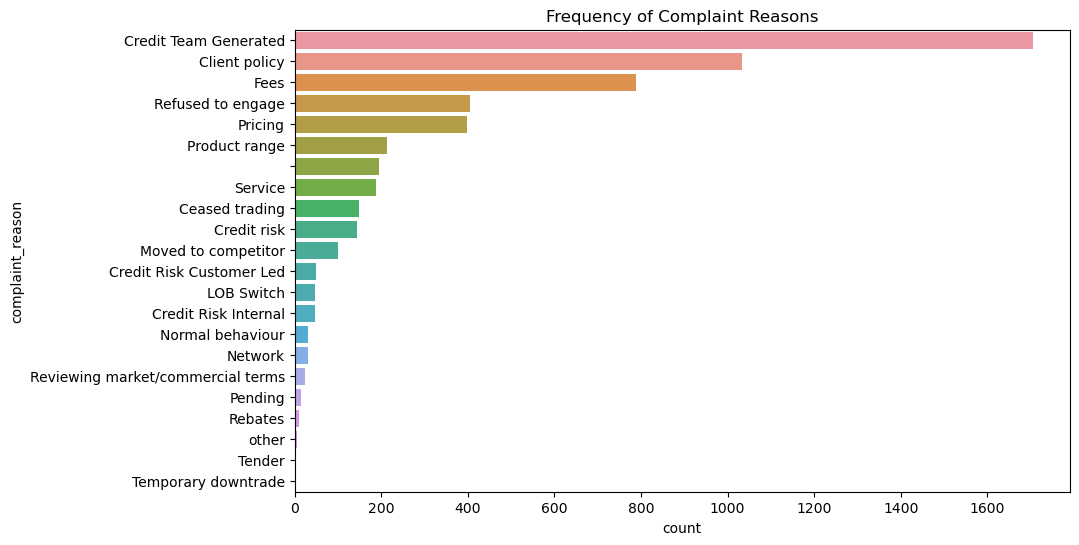

In [898]:
plt.figure(figsize=(10, 6))
sns.countplot(y='complaint_reason', data=complaints_df, order=complaints_df['complaint_reason'].value_counts().index)
plt.title("Frequency of Complaint Reasons")
plt.show()

In [899]:
customer_df.head()

,statusid,accountid,customerid,customername,producttype
0,13,8555.0,1076.0,name804,P6113
1,13,7070.0,3706.0,name5757,P1691
2,13,2587.0,1723.0,name8318,P9273
3,13,1713.0,435.0,name1205,P2948
4,13,3977.0,3178.0,name2490,P8721


In [900]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429574 entries, 0 to 429573
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   statusid      429574 non-null  object 
 1   accountid     421563 non-null  float64
 2   customerid    429574 non-null  float64
 3   customername  429574 non-null  object 
 4   producttype   429574 non-null  object 
dtypes: float64(2), object(3)
memory usage: 16.4+ MB


**accountid has 421563 non-null values out of 429574, meaning there are 8011 missing**
<br> **We have numerical and cathegorical columns**

In [901]:
monthly_reporting_df.head()

,customerid,report_month,live_cards,used_cards,ev_livecards,ev_usedcards,total_litres,diesel_litres,dd_litres,unleaded_litres,...,rev_E,rev_F,rev_G,rev_H,rev_I,rev_J,dd_margin,msc_fuel,rev_K,fuelonlytranscount
0,2746.0,2024-09-01,4.0,4.0,0.0,0.0,2178.37,2145.01,2145.01,0.0,...,-0.72,13.96,0.0,0.07,0.00,8.0,49.35,0.00,0.0,37.0
1,3234.0,2024-06-01,1.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
2,7786.0,2023-02-01,62.0,50.0,0.0,0.0,17160.17,17024.53,0.00,20.1,...,0.00,202.42,0.0,33.29,50.01,0.0,0.00,318.47,0.0,377.0
3,11714.0,2023-08-01,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0
4,10891.0,2024-07-01,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,...,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0


In [902]:
monthly_reporting_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235053 entries, 0 to 235052
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   customerid               230367 non-null  float64
 1   report_month             235053 non-null  object 
 2   live_cards               235053 non-null  float64
 3   used_cards               235053 non-null  float64
 4   ev_livecards             235053 non-null  float64
 5   ev_usedcards             235053 non-null  float64
 6   total_litres             235053 non-null  float64
 7   diesel_litres            235053 non-null  float64
 8   dd_litres                235053 non-null  float64
 9   unleaded_litres          235053 non-null  float64
 10  premium_diesel_litres    235053 non-null  float64
 11  premium_unleaded_litres  235053 non-null  float64
 12  ev_usage                 235053 non-null  float64
 13  ev_annualcardfees        235053 non-null  float64
 14  ev_m

**customerid has 230367 non-null values out of 235053, meaning there are 4686 missing**

## **Data Preprocessing**

#### **Table 1: Complaints**

In [903]:
# Drop rows with missing 'accountid' and 'closeddate' 
complaints_df.dropna(subset=['accountid'], inplace=True)
complaints_df.dropna(subset=['closeddate'], inplace=True)

In [904]:
# Convert dates to Datetime
complaints_df['createddate'] = pd.to_datetime(complaints_df['createddate'])
complaints_df['closeddate'] = pd.to_datetime(complaints_df['closeddate'])

In [905]:
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5285 entries, 0 to 5575
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   caseid               5285 non-null   float64       
 1   accountid            5285 non-null   float64       
 2   createddate          5285 non-null   datetime64[ns]
 3   closeddate           5285 non-null   datetime64[ns]
 4   complaint_reason     5285 non-null   object        
 5   complaint_subreason  5285 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(2)
memory usage: 289.0+ KB


In [906]:
# Drop any duplicates
complaints_df.drop_duplicates(inplace=True)

In [907]:
# Create a LabelEncoder instance for complaint_reason
le_complaint_reason = LabelEncoder()

complaints_df['complaint_reason_encoded'] = le_complaint_reason.fit_transform(complaints_df['complaint_reason'])

# Check the unique values and their encoded labels
complaint_reason_mapping = dict(zip(le_complaint_reason.classes_, le_complaint_reason.transform(le_complaint_reason.classes_)))

# Display the mapping for reference and verify the encoded column
complaint_reason_mapping, complaints_df[['complaint_reason', 'complaint_reason_encoded']].head()

complaints_df.head()

,caseid,accountid,createddate,closeddate,complaint_reason,complaint_subreason,complaint_reason_encoded
0,69.0,5228.0,2024-09-10 14:38:51,2024-09-12 06:57:58,Pricing,Not happy with commercial deal,12
1,4012.0,1833.0,2024-05-15 13:56:06,2024-05-15 13:56:15,Credit risk,Cancelled DD,6
2,2636.0,11137.0,2024-10-15 09:57:36,2024-10-22 11:14:28,Client policy,Company Merger/Restructure of business / redun...,2
3,1054.0,8129.0,2024-07-03 10:29:16,2024-07-03 10:29:24,Ceased trading,,1
4,2900.0,2662.0,2024-06-18 14:08:55,2024-06-18 14:09:02,Fees,other,7


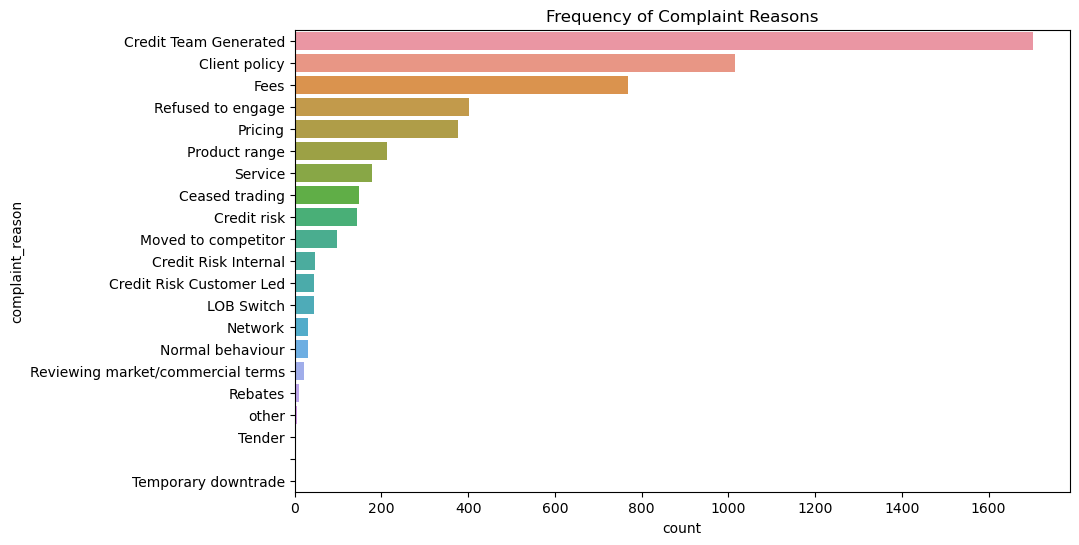

In [908]:
plt.figure(figsize=(10, 6))
sns.countplot(y='complaint_reason', data=complaints_df, order=complaints_df['complaint_reason'].value_counts().index)
plt.title("Frequency of Complaint Reasons")
plt.show()

In [909]:
# Set threshold for rare categories
threshold = 20

# Get complaint reasons with low frequencies
rare_reasons = complaints_df['complaint_reason'].value_counts()[complaints_df['complaint_reason'].value_counts() < threshold].index

# Filter out rows with rare complaint reasons
complaints_df_filtered = complaints_df[~complaints_df['complaint_reason'].isin(rare_reasons)].copy()


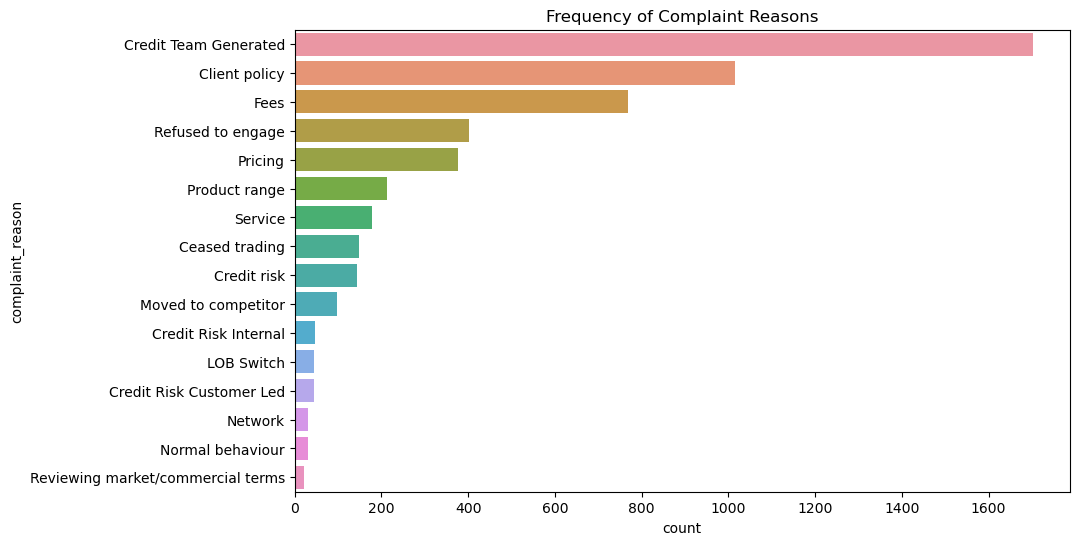

In [910]:
plt.figure(figsize=(10, 6))
sns.countplot(y='complaint_reason', data=complaints_df_filtered, order=complaints_df_filtered['complaint_reason'].value_counts().index)
plt.title("Frequency of Complaint Reasons")
plt.show()

In [911]:
# Drop the original 'complaint_reason' column
complaints_df_filtered = complaints_df_filtered.copy().drop(columns=['complaint_reason'])
complaints_df_filtered.head()


,caseid,accountid,createddate,closeddate,complaint_subreason,complaint_reason_encoded
0,69.0,5228.0,2024-09-10 14:38:51,2024-09-12 06:57:58,Not happy with commercial deal,12
1,4012.0,1833.0,2024-05-15 13:56:06,2024-05-15 13:56:15,Cancelled DD,6
2,2636.0,11137.0,2024-10-15 09:57:36,2024-10-22 11:14:28,Company Merger/Restructure of business / redun...,2
3,1054.0,8129.0,2024-07-03 10:29:16,2024-07-03 10:29:24,,1
4,2900.0,2662.0,2024-06-18 14:08:55,2024-06-18 14:09:02,other,7


In [912]:

le_complaint_subreason = LabelEncoder()

# Apply label encoding to the 'complaint_subreason' column
complaints_df_filtered['complaint_subreason_encoded'] = le_complaint_subreason.fit_transform(complaints_df_filtered['complaint_subreason'])

# Check the unique values and their encoded labels
complaint_subreason_mapping = dict(zip(le_complaint_subreason.classes_, le_complaint_subreason.transform(le_complaint_subreason.classes_)))

# Display the mapping for reference and verify the encoded column
complaint_subreason_mapping, complaints_df_filtered[['complaint_subreason', 'complaint_subreason_encoded']].head()

complaints_df_filtered.head()

,caseid,accountid,createddate,closeddate,complaint_subreason,complaint_reason_encoded,complaint_subreason_encoded
0,69.0,5228.0,2024-09-10 14:38:51,2024-09-12 06:57:58,Not happy with commercial deal,12,41
1,4012.0,1833.0,2024-05-15 13:56:06,2024-05-15 13:56:15,Cancelled DD,6,11
2,2636.0,11137.0,2024-10-15 09:57:36,2024-10-22 11:14:28,Company Merger/Restructure of business / redun...,2,17
3,1054.0,8129.0,2024-07-03 10:29:16,2024-07-03 10:29:24,,1,0
4,2900.0,2662.0,2024-06-18 14:08:55,2024-06-18 14:09:02,other,7,59


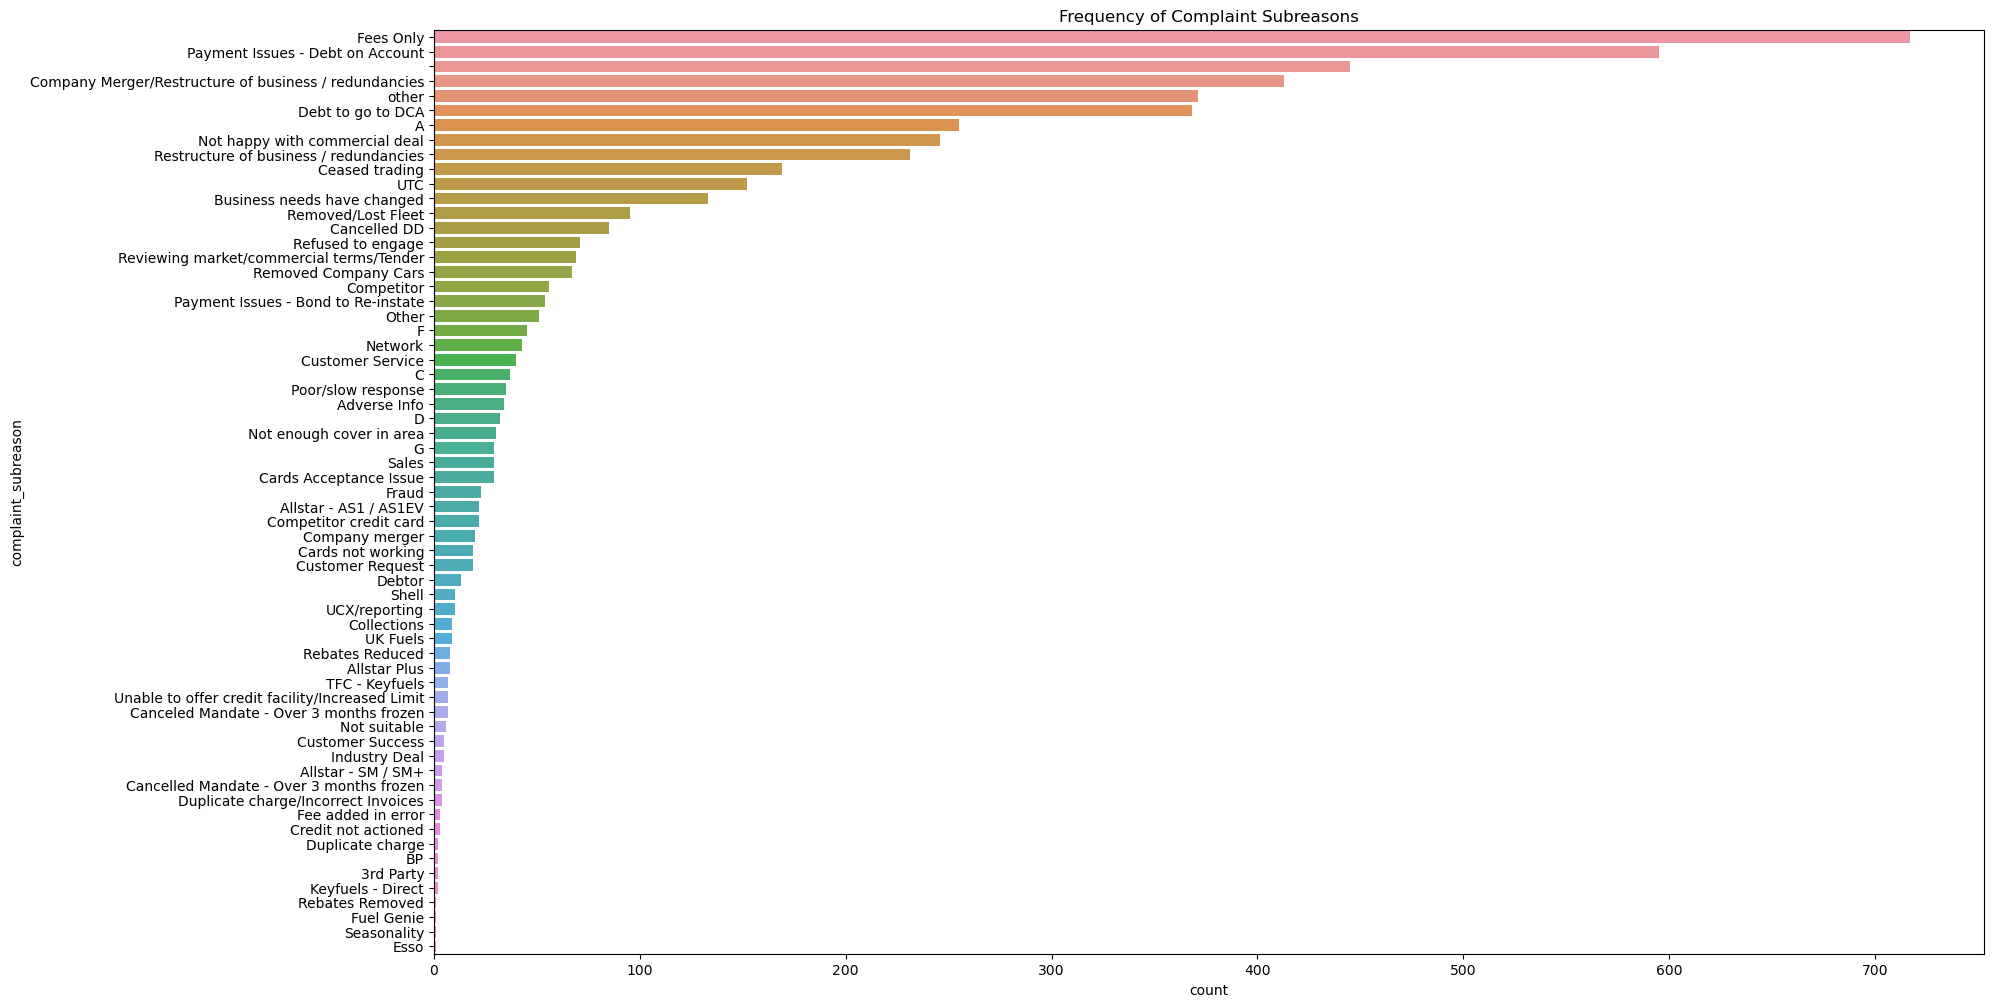

In [913]:

plt.figure(figsize=(20, 12))
sns.countplot(y='complaint_subreason', data=complaints_df, order=complaints_df['complaint_subreason'].value_counts().index)
plt.title("Frequency of Complaint Subreasons")
plt.show()

In [914]:
# Drop the original 'complaint_subreason' column
complaints_df_filtered = complaints_df_filtered.copy().drop(columns=['complaint_subreason'])
complaints_df_filtered.head()

,caseid,accountid,createddate,closeddate,complaint_reason_encoded,complaint_subreason_encoded
0,69.0,5228.0,2024-09-10 14:38:51,2024-09-12 06:57:58,12,41
1,4012.0,1833.0,2024-05-15 13:56:06,2024-05-15 13:56:15,6,11
2,2636.0,11137.0,2024-10-15 09:57:36,2024-10-22 11:14:28,2,17
3,1054.0,8129.0,2024-07-03 10:29:16,2024-07-03 10:29:24,1,0
4,2900.0,2662.0,2024-06-18 14:08:55,2024-06-18 14:09:02,7,59


In [ ]:
# Create a new duration feature: the difference between the date of the creation of the case and the day it was closed
complaints_df_filtered['closeddate'] = complaints_df_filtered['closeddate'].fillna(pd.Timestamp('2099-12-31'))

complaints_df_filtered['duration'] = (complaints_df_filtered['closeddate'] - complaints_df_filtered['createddate']).dt.total_seconds() / 60
complaints_df_filtered['duration'] = complaints_df_filtered['duration'].astype(float)
complaints_df_filtered.head()

,caseid,accountid,createddate,closeddate,complaint_reason_encoded,complaint_subreason_encoded,duration
0,69.0,5228.0,2024-09-10 14:38:51,2024-09-12 06:57:58,12,41,2419.116667
1,4012.0,1833.0,2024-05-15 13:56:06,2024-05-15 13:56:15,6,11,0.150000
2,2636.0,11137.0,2024-10-15 09:57:36,2024-10-22 11:14:28,2,17,10156.866667
3,1054.0,8129.0,2024-07-03 10:29:16,2024-07-03 10:29:24,1,0,0.133333
4,2900.0,2662.0,2024-06-18 14:08:55,2024-06-18 14:09:02,7,59,0.116667


In [916]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
complaints_df_filtered['normalized_duration'] = scaler.fit_transform(complaints_df_filtered[['duration']])

In [917]:
# Drop rows with the unlabeled category
complaints_df_c = complaints_df_filtered[complaints_df_filtered['complaint_subreason_encoded'] != '']

# Drop uneccessary columns that are not relevant for the ptrdiction process; they won't provide us with meaningful insights
columns_to_drop = ['caseid', 'createddate', 'closeddate']

complaints_df_cleaned = complaints_df_c.drop(columns=columns_to_drop, axis=1)

print(complaints_df_cleaned.columns)

Index(['accountid', 'complaint_reason_encoded', 'complaint_subreason_encoded',
       'duration', 'normalized_duration'],
      dtype='object')


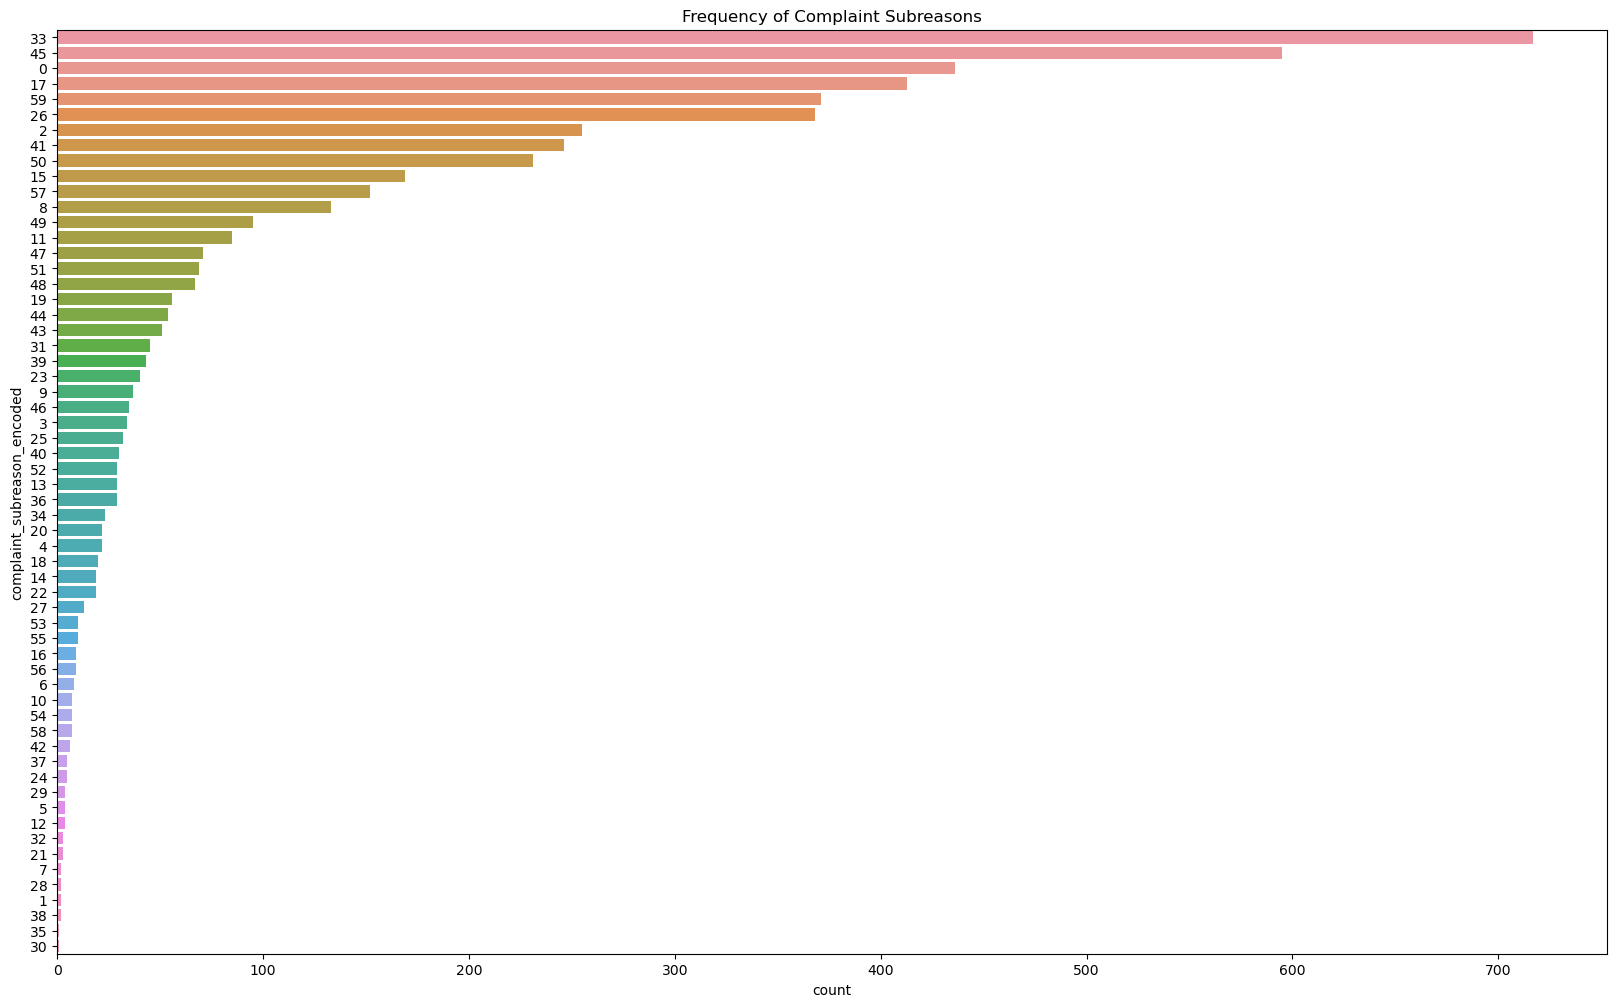

In [918]:
plt.figure(figsize=(20, 12))
sns.countplot(y='complaint_subreason_encoded', data=complaints_df_cleaned, order=complaints_df_cleaned['complaint_subreason_encoded'].value_counts().index)
plt.title("Frequency of Complaint Subreasons")
plt.show()

In [919]:
complaints_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5266 entries, 0 to 5575
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   accountid                    5266 non-null   float64
 1   complaint_reason_encoded     5266 non-null   int64  
 2   complaint_subreason_encoded  5266 non-null   int64  
 3   duration                     5266 non-null   float64
 4   normalized_duration          5266 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 246.8 KB


In [920]:
complaints_df_cleaned.to_csv('cleaned_complaints_table.csv', index=False)

#### **Table 2: Customers**

In [921]:
# Drop rows with missing "accountid" values
customer_df.dropna(subset=['accountid'], inplace=True)

In [922]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421563 entries, 0 to 429573
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   statusid      421563 non-null  object 
 1   accountid     421563 non-null  float64
 2   customerid    421563 non-null  float64
 3   customername  421563 non-null  object 
 4   producttype   421563 non-null  object 
dtypes: float64(2), object(3)
memory usage: 19.3+ MB


In [923]:
# Remove duplicate rows 
customer_df.drop_duplicates(inplace=True)

In [924]:
# Ensure 'customerid' is unique if it represents a unique customer
if customer_df['customerid'].duplicated().any():
    customer_df = customer_df.drop_duplicates(subset=['customerid'])

In [ ]:
# Drop customername and statusid as they are not predictive
columns_to_drop = [ 'customername', 'statusid']
customer_df_cleaned = customer_df.drop(columns=columns_to_drop, axis=1)

print(customer_df_cleaned.columns)


Index(['accountid', 'customerid', 'producttype'], dtype='object')


In [926]:
# Encode producttype column
le_producttype = LabelEncoder()

# Apply label encoding
customer_df_cleaned['producttype_encoded'] = le_producttype.fit_transform(customer_df_cleaned['producttype'])

# Drop the original 'complaint_producttype' column
customer_df_cleaned.drop(columns=['producttype'], inplace=True)

customer_df_cleaned.head()

,accountid,customerid,producttype_encoded
0,8555.0,1076.0,7774
1,7070.0,3706.0,2939
2,2587.0,1723.0,11214
3,1713.0,435.0,4317
4,3977.0,3178.0,10613


In [927]:
customer_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12004 entries, 0 to 422435
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   accountid            12004 non-null  float64
 1   customerid           12004 non-null  float64
 2   producttype_encoded  12004 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 375.1 KB


In [928]:
customer_df_cleaned.to_csv('cleaned_customer_table.csv', index=False)

#### **Table 3: Monthly Reports**

In [929]:
# Drop rows with missing "customerid" values
monthly_reporting_df.dropna(subset=['customerid'], inplace=True)

In [930]:
# check for missing values in each column
print(monthly_reporting_df.isnull().sum())


customerid                 0
report_month               0
live_cards                 0
used_cards                 0
ev_livecards               0
ev_usedcards               0
total_litres               0
diesel_litres              0
dd_litres                  0
unleaded_litres            0
premium_diesel_litres      0
premium_unleaded_litres    0
ev_usage                   0
ev_annualcardfees          0
ev_monthlycardfees         0
rev_A                      0
rev_B                      0
rev_C                      0
rev_D                      0
rev_E                      0
rev_F                      0
rev_G                      0
rev_H                      0
rev_I                      0
rev_J                      0
dd_margin                  0
msc_fuel                   0
rev_K                      0
fuelonlytranscount         0
dtype: int64


In [931]:
monthly_reporting_df['report_month'] = pd.to_datetime(monthly_reporting_df['report_month'])

In [932]:
# Remove duplicate rows 
monthly_reporting_df.drop_duplicates(inplace=True)

In [933]:
monthly_reporting_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230367 entries, 0 to 235052
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   customerid               230367 non-null  float64       
 1   report_month             230367 non-null  datetime64[ns]
 2   live_cards               230367 non-null  float64       
 3   used_cards               230367 non-null  float64       
 4   ev_livecards             230367 non-null  float64       
 5   ev_usedcards             230367 non-null  float64       
 6   total_litres             230367 non-null  float64       
 7   diesel_litres            230367 non-null  float64       
 8   dd_litres                230367 non-null  float64       
 9   unleaded_litres          230367 non-null  float64       
 10  premium_diesel_litres    230367 non-null  float64       
 11  premium_unleaded_litres  230367 non-null  float64       
 12  ev_usage             

In [934]:
# Scale Revenue Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

revenue_columns = ['rev_A', 'rev_B', 'rev_C', 'rev_D', 'rev_E', 'rev_F', 'rev_G', 'rev_H', 'rev_I', 'rev_J', 'rev_K']
monthly_reporting_df[revenue_columns] = scaler.fit_transform(monthly_reporting_df[revenue_columns])


In [ ]:
# Create a new total revenue column
monthly_reporting_df['total_revenue'] = monthly_reporting_df[revenue_columns].sum(axis=1)


In [936]:
# Drop uneccessary columns that are not relevant for the ptrdiction process; they won't provide us with meaningful insights
columns_to_drop = ['report_month', 'rev_A', 'rev_B', 'rev_C', 'rev_D', 'rev_E', 'rev_F', 'rev_G', 'rev_H', 'rev_I', 'rev_J', 'rev_K']
reporting_df_cleaned = monthly_reporting_df.drop(columns=columns_to_drop, axis=1)

print(reporting_df_cleaned.columns)

Index(['customerid', 'live_cards', 'used_cards', 'ev_livecards',
       'ev_usedcards', 'total_litres', 'diesel_litres', 'dd_litres',
       'unleaded_litres', 'premium_diesel_litres', 'premium_unleaded_litres',
       'ev_usage', 'ev_annualcardfees', 'ev_monthlycardfees', 'dd_margin',
       'msc_fuel', 'fuelonlytranscount', 'total_revenue'],
      dtype='object')


In [937]:
# Check if there are missing values in a specific column
missing_values = reporting_df_cleaned['total_revenue'].isnull().any()
print(f"Does 'column_name' have missing values? {missing_values}")


Does 'column_name' have missing values? False


In [938]:
# Create card usage ratios
reporting_df_cleaned['card_utilization_ratio'] = reporting_df_cleaned['used_cards'] / reporting_df_cleaned['live_cards']
reporting_df_cleaned['ev_card_utilization_ratio'] = reporting_df_cleaned['ev_usedcards'] / reporting_df_cleaned['ev_livecards']



In [939]:
# Drop rows with missing values
# Replace infinite values with NaN to handle problematic data
reporting_df_cleaned['card_utilization_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
reporting_df_cleaned['ev_card_utilization_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in specific columns
reporting_df_cleaned.dropna(subset=['card_utilization_ratio', 'ev_card_utilization_ratio'], inplace=True)

# Initialize the scaler
scaler = StandardScaler()

# Scale the columns
reporting_df_cleaned['card_utilization_ratio'] = scaler.fit_transform(
    reporting_df_cleaned['card_utilization_ratio'].values.reshape(-1, 1)
).flatten()

reporting_df_cleaned['ev_card_utilization_ratio'] = scaler.fit_transform(
    reporting_df_cleaned['ev_card_utilization_ratio'].values.reshape(-1, 1)
).flatten()


In [940]:
reporting_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11590 entries, 33 to 234969
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 11590 non-null  float64
 1   live_cards                 11590 non-null  float64
 2   used_cards                 11590 non-null  float64
 3   ev_livecards               11590 non-null  float64
 4   ev_usedcards               11590 non-null  float64
 5   total_litres               11590 non-null  float64
 6   diesel_litres              11590 non-null  float64
 7   dd_litres                  11590 non-null  float64
 8   unleaded_litres            11590 non-null  float64
 9   premium_diesel_litres      11590 non-null  float64
 10  premium_unleaded_litres    11590 non-null  float64
 11  ev_usage                   11590 non-null  float64
 12  ev_annualcardfees          11590 non-null  float64
 13  ev_monthlycardfees         11590 non-null  float6

In [941]:
reporting_df_cleaned.to_csv('cleaned_reporting_table.csv', index=False)

#### **Merge Tables**
##### Merge all the three tables in order to have more features for the prediction

In [942]:
# Merge Complaints with Customer Data

# Merge the tables on a common column -> 'accountid' 
merge_df = pd.merge(complaints_df_cleaned, customer_df_cleaned, on='accountid', how='inner')

# Drop accountid after merging as it doesn't provide us with any meaningful information
merge_df = merge_df.drop(columns=['accountid'])

# Display the merged DataFrame
merge_df.head()


,complaint_reason_encoded,complaint_subreason_encoded,duration,normalized_duration,customerid,producttype_encoded
0,12,41,2419.116667,1.769726e-02,6646.0,10437
1,6,11,0.150000,1.097338e-06,6699.0,8104
2,2,17,10156.866667,7.430343e-02,1238.0,8933
3,1,0,0.133333,9.754115e-07,2034.0,3225
4,5,26,0.000000,0.000000e+00,2034.0,3225


In [943]:
# Complaints & Customer Data with the Monthly Reports

# Merge the tables on a common column -> 'customerid' 
merged_df = pd.merge(merge_df, reporting_df_cleaned, on='customerid', how='inner')

# Drop accountid as it doesn't provide us with any meaningful information
merged_df = merged_df.drop(columns=['customerid'])


merged_df.head()


,complaint_reason_encoded,complaint_subreason_encoded,duration,normalized_duration,producttype_encoded,live_cards,used_cards,ev_livecards,ev_usedcards,total_litres,...,premium_unleaded_litres,ev_usage,ev_annualcardfees,ev_monthlycardfees,dd_margin,msc_fuel,fuelonlytranscount,total_revenue,card_utilization_ratio,ev_card_utilization_ratio
0,5,45,0.0,0.0,7685,1.0,0.0,1.0,0.0,0.00,...,0.0,0.0,0.0,2.5,0.0,0.00,0.0,-0.968608,-1.649813,-0.715825
1,5,45,0.0,0.0,7685,1.0,1.0,1.0,0.0,275.21,...,0.0,0.0,0.0,2.5,0.0,4.69,4.0,-0.968608,1.462440,-0.715825
2,5,45,0.0,0.0,7685,1.0,1.0,1.0,0.0,76.04,...,0.0,0.0,0.0,2.5,0.0,2.49,1.0,-0.905920,1.462440,-0.715825
3,5,45,0.0,0.0,7685,1.0,1.0,1.0,0.0,125.76,...,0.0,0.0,0.0,2.5,0.0,2.48,3.0,-0.968608,1.462440,-0.715825
4,5,45,0.0,0.0,7685,1.0,1.0,1.0,0.0,188.60,...,0.0,0.0,0.0,2.5,0.0,3.86,3.0,-0.968608,1.462440,-0.715825


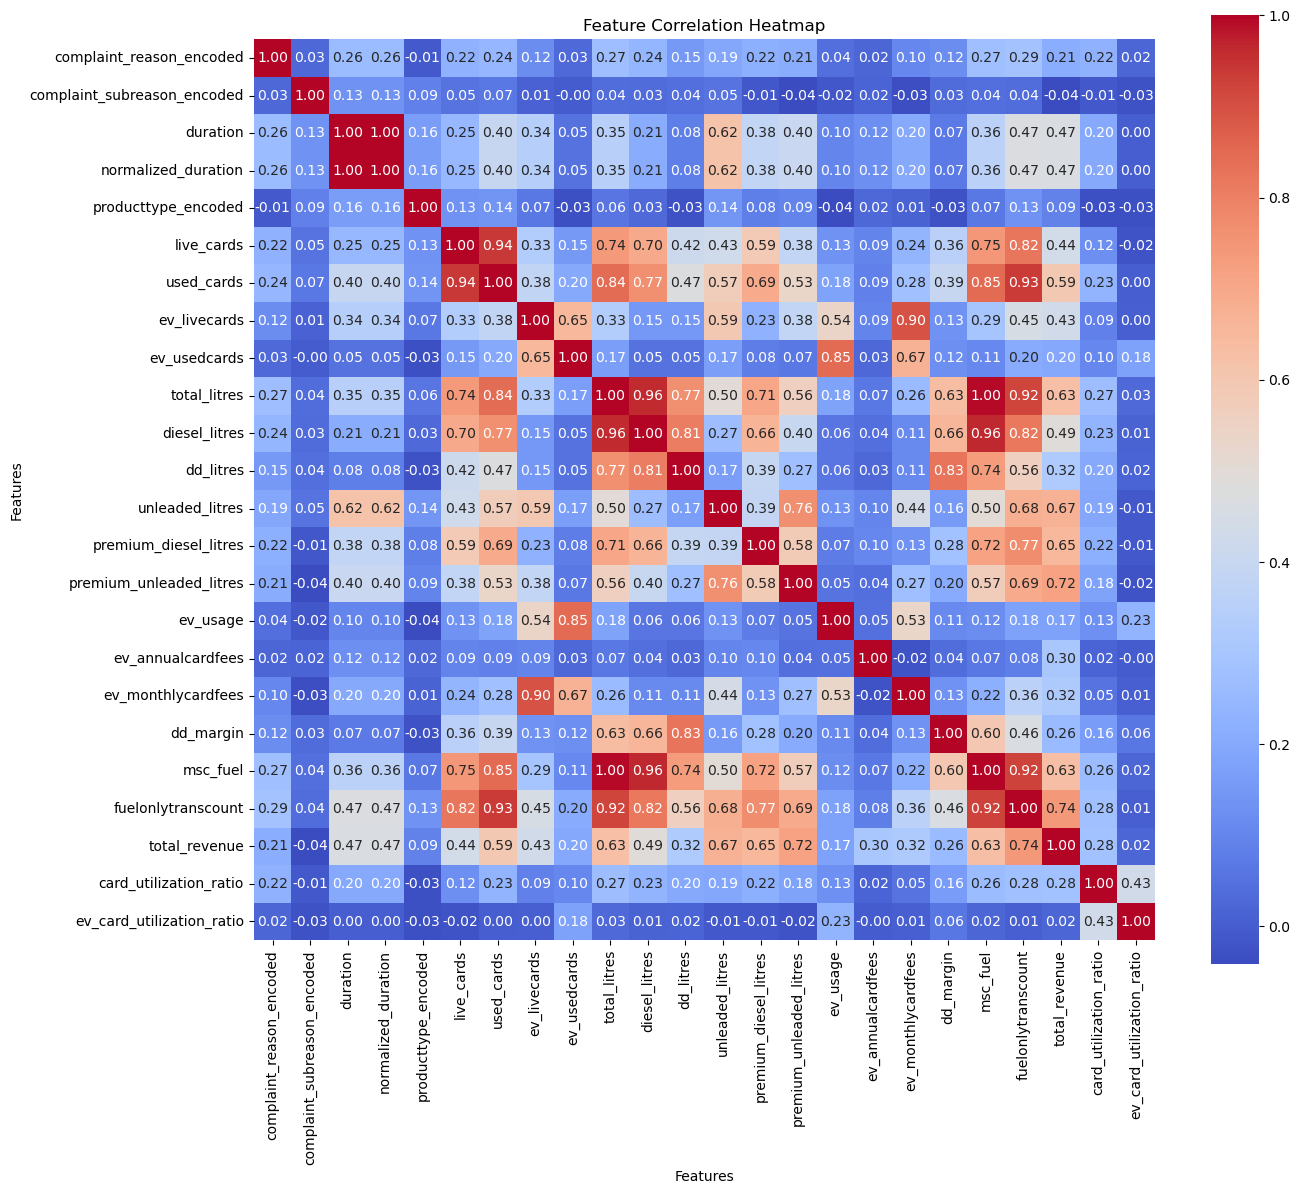

In [ ]:
# Calculate the correlation matrix for all numeric columns
correlation_matrix = merged_df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,  
    fmt=".2f",   
    cmap="coolwarm",  
    cbar=True,  
    square=True  
)
plt.title('Feature Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

##### HeatMap Insights
1. Highly Correlated Features (might introduce redundancy)
- live_cards and used_cards: strong relationship that active cards tend to get utilized often
- premium_unleaded_litres and unleaded_litres: suggests a substantial overlap between these two variables, likely because premium is a subset of unleaded fuel usage
- msc_fuel and fuelonlytranscount
- ev_card_utilization_ratio and card_utilization_ratio

2. Weak Correlations with the target variable complaints
- most features have low correlations with the target, which indicates that these features alone may not strongly explain the target variable and a combination of features or more complex relationships might be needed for predictive power

##### Further Feature Aggregations
1. total_live_cards
<br>This feature represents the total number of live (active) cards
<br>Correlation with the target variable might show if larger active card bases correlate with more complaints (due to higher usage) or fewer complaints (due to better customer satisfaction)

2. total_activity_rate
<br>Combines utilization rates for both regular and EV cards, giving an aggregated measure of how actively the cards are being used

3. total_used_cards
<br>Determine the overall activity rate or engagement level of the customer base
<br>If correlated with complaint reason, this feature might show whether higher usage correlates with increased complaints

4. product_duration
<br>This feature demonstrates how specific product types are associated with longer or shorter complaint durations
<br>Can help differentiate cases not just by duration but by the significance of the product type


In [945]:

merged_df['total_live_cards'] = merged_df['live_cards']+merged_df['ev_livecards']
merged_df['total_activity_rate'] = merged_df['card_utilization_ratio']+merged_df['ev_card_utilization_ratio']
merged_df['total_used_cards'] = merged_df['used_cards']+merged_df['ev_usedcards']
merged_df['product_duration'] = merged_df['normalized_duration']*merged_df['producttype_encoded'] 


In [946]:
# Drop possible redundant columns
merged_df = merged_df.drop(columns=[ 
    'ev_card_utilization_ratio', 
    'live_cards', 
    'diesel_litres', 
    'msc_fuel',
    'duration',
    'used_cards',
    'fuelonlytranscount',
    'ev_usedcards',
    'card_utilization_ratio',
    'dd_litres'
])


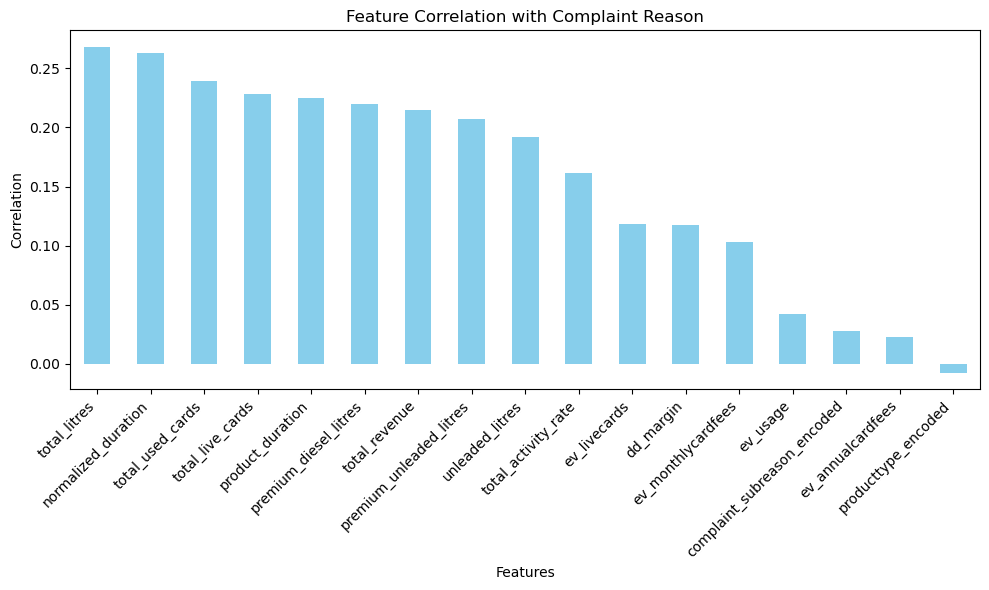

In [947]:

# Calculate correlation of all numerical features with 'complaint_reason'
correlations = merged_df.corr(numeric_only=True)['complaint_reason_encoded'].sort_values(ascending=False)

# Plot the correlations as a bar plot
plt.figure(figsize=(10, 6))
correlations.drop('complaint_reason_encoded').plot(kind='bar', color='skyblue')  # Drop self-correlation
plt.title("Feature Correlation with Complaint Reason")
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### BarPlot Insights:
1. Highly Correlated Features 
- total_litres, normalized_duration, total_used_cards and total_live_cards: suggest they have significant predictive power for determining complaint reasons
2. Moderately Correlated Features
- product_duration, premium_diesel_litres and total_revenue: suggest these features contribute meaningfully to complaints but are not the primary drivers.
3. Low Correlated Features
- ev_usage, ev_annualcardfees, and producttype_encoded: suggest they have limited predictive power for the target variable.

## **Prepare the baseline for the prediction**

In [948]:
# Define X matrix and the target vector y
target = 'complaint_reason_encoded'
X = merged_df.drop([target], axis = 1) 
y = merged_df[target] 

In [949]:
f_scores, p_values = f_classif(X, y)

anova_df = pd.DataFrame({'Feature': X.columns, 'F-Score': f_scores, 'P-Value': p_values})
anova_df.sort_values(by='F-Score', ascending=False, inplace=True)

print(anova_df)


                        Feature     F-Score        P-Value
4                  total_litres  119.749798  8.515736e-300
15             total_used_cards   90.219413  2.511422e-234
13             total_live_cards   81.693699  2.484776e-214
16             product_duration   79.861307  5.774748e-210
0   complaint_subreason_encoded   73.076576  1.401529e-193
1           normalized_duration   71.918868  9.492758e-191
6         premium_diesel_litres   65.767378  1.562598e-175
12                total_revenue   58.974565  2.223471e-158
5               unleaded_litres   50.304108  6.215633e-136
7       premium_unleaded_litres   46.398436  1.293591e-125
11                    dd_margin   26.127443   5.624137e-70
14          total_activity_rate   20.408526   1.078668e-53
3                  ev_livecards   19.705554   1.117128e-51
10           ev_monthlycardfees   18.191305   2.494442e-47
2           producttype_encoded   17.502725   2.385720e-45
8                      ev_usage    6.839690   7.441896e-

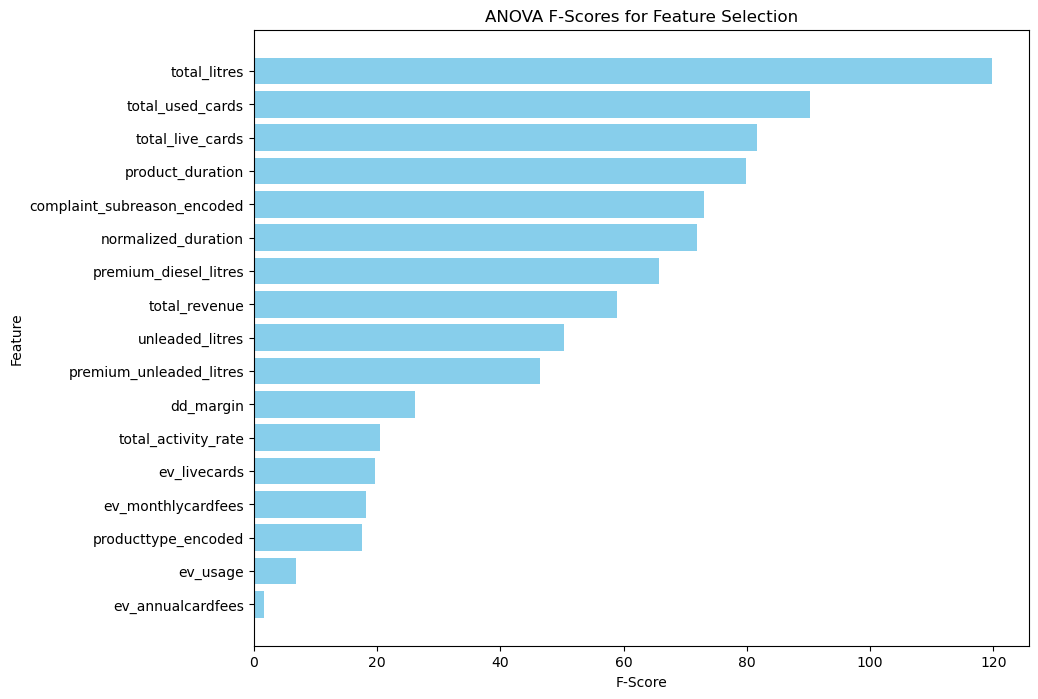

In [950]:

# Plot the F-scores
plt.figure(figsize=(10, 8))
plt.barh(anova_df['Feature'], anova_df['F-Score'], color='skyblue')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.title('ANOVA F-Scores for Feature Selection')
plt.gca().invert_yaxis()  
plt.show()


##### BarPlot Insights:
ANOVA F-Scores for Feature Selection, providing insights into which features have the most discriminative power in relation to the target variable 
1. Dominant Features:
- total_litres, total_used_cards, and total_live_cards: these features are the most predictive of the complaint reasons
- product_duration and complaint_subreason_encoded: these features have a big predictive power as well
2. Less Predictive:
- ev_annualcardfees, ev_usage, and producttype_encoded: these features may not significantly contribute to predicting complaint reasons and could potentially be removed to simplify the model.


In [951]:
# Check class distribution
class_counts = y.value_counts()
print(class_counts)


complaint_reason_encoded
5     984
2     754
7     548
12    354
15    218
13    149
17    143
16     91
1      66
6      45
4      31
8      26
3      24
9      12
11      5
10      5
Name: count, dtype: int64


In [952]:
# Identify rare classes
rare_classes = [key for key, value in y.value_counts().items() if value < 5]

# Filter out rare classes
X_filtered = X[~y.isin(rare_classes)]
y_filtered = y[~y.isin(rare_classes)]


In [953]:
# Check class distribution
class_counts = y.value_counts()
print(class_counts)

complaint_reason_encoded
5     984
2     754
7     548
12    354
15    218
13    149
17    143
16     91
1      66
6      45
4      31
8      26
3      24
9      12
11      5
10      5
Name: count, dtype: int64


In [954]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, train_size = 0.70, random_state = 42)

print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 2418 samples in the training dataset
There are 1037 samples in the testing dataset
Each sample has 17 features


In [955]:
""""
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

'"\n# Normalize features\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n'

## **Define the models**

In [956]:
model_lbls = [
             'adb',  # adaboost,
             'rf',  # random forest
             'dt'   # decision tree
            ]

models = {

    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(random_state=42),
           'param': [{'n_estimators':[10,20,30,40,50]
                     ,'learning_rate':[0.2,0.5,0.75,1,1.25,1.5]}]
          },
    'rf': {'name': 'Random forest       ',
           'estimator': RandomForestClassifier(random_state=42),
           'param': [{'max_depth': [*range(1,9)]
                     ,'n_estimators':[*range(10,50,10)]}]
                     ,'min_samples_split': [12] 
          },
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=42), 
           'param': [{'max_depth': [*range(1,11)],'class_weight':['balanced']}],
          }
        

}

## **Score functions**

In [957]:
scorings = ['accuracy','precision_macro','recall_macro','f1_macro']

In [958]:
from sklearn.model_selection import ParameterGrid

trials = {lbl: len(list(ParameterGrid(models[lbl]['param']))) for lbl in models.keys()}
trials

{'adb': 30, 'rf': 32, 'dt': 10}

## **Loop on scores and for each score, loop on the model labels**

In [959]:
from sklearn.model_selection import cross_val_score

# Initialize containers for results
clfs = []
results = pd.DataFrame(columns=[
    'scoring',
    'model',
    'best_params',
    'accuracy',
    'validation_accuracy', 
    'cross_val_accuracy',
    'precision_macro',
    'recall_macro',
    'f1_macro'
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop through scorings and models
for scoring in scorings:
    for m in model_lbls:
        # Initialize GridSearchCV
        clf = GridSearchCV(
            models[m]['estimator'], 
            models[m]['param'], 
            cv=cv, 
            scoring=scoring
        )

        # Fit the model
        clf.fit(X_train, y_train)
        clfs.append(clf)
        
        # Predict on the test set
        y_true, y_pred = y_test, clf.predict(X_test)

        # Extract validation accuracy from GridSearchCV
        validation_accuracy = clf.best_score_

        # Perform cross-validation on the full dataset
        cross_val_scores = cross_val_score(
            clf.best_estimator_, 
            X_train, 
            y_train, 
            cv=5, 
            scoring=scoring
        )
        cross_val_accuracy = cross_val_scores.mean()

        # Generate classification report for the test set
        cr = classification_report(
            y_true, 
            y_pred, 
            output_dict=True,
            zero_division=0
        )

        # Append results
        results.loc[len(results)] = [
            scoring,
            models[m]['name'],
            clf.best_params_,
            cr['accuracy'],  # Test accuracy
            validation_accuracy,  
            cross_val_accuracy,  # Cross-validated accuracy
            cr['weighted avg']['precision'],
            cr['weighted avg']['recall'],
            cr['weighted avg']['f1-score']
        ]



In [961]:
# Pivot table for the results
pivot_results = results.pivot_table(
    index='model', 
    values=['accuracy', 'validation_accuracy', 'cross_val_accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
    aggfunc='first'  
)

pivot_results = pivot_results.sort_values(by='accuracy', ascending=False)
display(pivot_results.style.format(precision=3).set_caption("Model Results"))

,accuracy,cross_val_accuracy,f1_macro,precision_macro,recall_macro,validation_accuracy
model,,,,,,
Random forest,0.878,0.879,0.854,0.881,0.878,0.868
Decision Tree,0.786,0.789,0.835,0.929,0.786,0.744
AdaBoost,0.711,0.704,0.646,0.618,0.711,0.703


##### Models Insights:
1. Best Performing Model: Random Forest
- Accuracy: 0.878 - The model performs well on the test data.
- Cross-Validation Accuracy: 0.879 - The model's performance is consistent across folds during cross-validation, suggesting it's generalizing well to unseen data.
- F1_macro: 0.854 - A good balance between precision and recall for all classes, indicating it handles class imbalances well.
- Precision_macro: 0.881 - The model is precise in its predictions, with a high ratio of correctly predicted positive observations.
- Recall_macro: 0.878 - The model is sensitive, correctly identifying most positive cases.
- Validation Accuracy: 0.868 - Very close to the test accuracy, showing the model is stable and not overfitting.
- Its consistency across accuracy and cross-validation accuracy shows robustness.

2. Decision Tree
- Accuracy: 0.786 - Lower than Random Forest, but decent performance.
- Cross-Validation Accuracy: 0.789 - Close to the test accuracy, indicating stable generalization.
- F1_macro: 0.835 - A good balance between precision and recall, slightly higher than accuracy suggests it’s handling imbalanced classes reasonably well.
- Precision_macro: 0.929 - Very high, indicating the model is confident about its predictions, though this might come at the cost of recall.
- Recall_macro: 0.786 - Matches accuracy, indicating it identifies most positive cases well, though not as effectively as Random Forest.
- Validation Accuracy: 0.744 - A noticeable drop compared to accuracy and cross-validation accuracy suggests some overfitting.
- Performs well but is clearly less robust than Random Forest.
- Precision is very high compared to recall, meaning it’s confident but might miss some cases.
- Validation accuracy being lower than test accuracy suggests some overfitting or sensitivity to the training data.

3. AdaBoost
- Accuracy: 0.711 - Lowest test accuracy among the models.
- Cross-Validation Accuracy: 0.704 - Close to test accuracy, indicating consistency across folds.
- F1_macro: 0.646 - Indicates a relatively weaker balance between precision and recall compared to other models.
- Precision_macro: 0.618 - Low precision, suggesting the model struggles with making correct predictions.
- Recall_macro: 0.711 - On par with accuracy, indicating it identifies positive cases decently.
- Validation Accuracy: 0.703 - Matches closely with cross-validation accuracy, showing stability in performance.
- The weakest model in this comparison.
- Relatively consistent between test, validation, and cross-validation accuracy, but overall performance is lower.
- Struggles with precision, indicating it’s not as effective in distinguishing between classes.

4. Which models will be not taken into consideration but still we can get insights from them?
<br>4.1 Decision Tree:
- prone to overfitting
- Decision Tree provided a simpler, interpretable baseline but lacked the robustness required for this dataset
<br>4.2 AdaBoost:
- AdaBoost is sensitive to noisy data or datasets with less discriminative features
- AdaBoost might require further tuning or a different dataset composition to perform better. It highlighted the importance of feature engineering in boosting algorithms

5. The Value of Random Forest 
- Random Forest builds multiple Decision Trees on bootstrapped subsets of the training data and combines their outputs through majority voting (for classification). This reduces the variance seen in single Decision Trees, making the model more stable and better at generalizing to unseen data.
- In our dataset, this stability likely helped mitigate the overfitting tendencies observed in single-tree models like Decision Tree.
- Unlike boosting models such as AdaBoost, which are sensitive to noisy or less informative features, Random Forest is inherently robust. It assigns lower importance to irrelevant features during tree splitting and voting

- The dataset combines categorical features and numerical features with potential multicollinearity and non-linear interactions. Random Forest's ensemble approach effectively addresses these challenges while offering robust performance, interpretability, and flexibility.




In [962]:
# Find the best model based on accuracy
best_model_row = results.loc[results['accuracy'].idxmax()]

# Extract and print the best parameters and the corresponding model name
best_model_name = best_model_row['model']
best_model_params = best_model_row['best_params']
best_model_accuracy = best_model_row['accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Parameters: {best_model_params}")
print(f"Accuracy: {best_model_accuracy:.3f}")


Best Model: Random forest       
Best Parameters: {'max_depth': 8, 'n_estimators': 30}
Accuracy: 0.878


In [963]:
# Use Permutation Importance to measure the importance of each feature in making predictions

from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(clf.best_estimator_, X_test, y_test, scoring='accuracy', random_state=42)
perm_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_importance.importances_mean
}).sort_values(by='importance', ascending=False)

print(perm_importance_df)


                        feature  importance
0   complaint_subreason_encoded    0.362777
1           normalized_duration    0.360656
13             total_live_cards    0.045516
2           producttype_encoded    0.038187
4                  total_litres    0.030473
16             product_duration    0.023722
12                total_revenue    0.013693
3                  ev_livecards    0.010415
10           ev_monthlycardfees    0.008486
14          total_activity_rate    0.001350
9             ev_annualcardfees    0.000579
6         premium_diesel_litres    0.000000
7       premium_unleaded_litres    0.000000
5               unleaded_litres    0.000000
11                    dd_margin    0.000000
15             total_used_cards    0.000000
8                      ev_usage    0.000000


##### Insights:
1. Strenghts:
- The top two features (complaint_subreason_encoded and normalized_duration) are highly predictive. These features likely have a strong, meaningful relationship with the target variable
- The moderate contribution of features like total_live_cards, producttype_encoded, and total_litres suggests the model considers diverse aspects of the dataset
2. Concerns:
- Heavy reliance on just two features may indicate overfitting to those specific attributes
- Zero importance for many features might suggest that the dataset has redundant or irrelevant variables. This could mean the dataset needs further refinement to focus on informative features
3. Potential Actions:
<br>3.1 Check for data leakage: 
<br>3.1.1 complaint_subreason_encoded and normalized_duration are not derived from complaint_reason
<br>3.1.2 We can use the ANOVA analysis from before to compare for potential data leakage: complaint_subreason_encoded doesn't have unusually high F-score which is disproportionately important compared to other features, the same goes for normalized_duration
<br> 3.2 Prune or Enhance Unimportant Features
<br>3.3 Add more diverse data to reduce the dominance of these two features


Additional Comments:
- I don't know how to adress further the problem with the two columns that have a major impact on the prediction. I tried using different tests to check what is also the correlation with the target but it doesn't appear to be highly-correlated. These are the only insights and interpretations of the data I can derive for now. Further investigation should be done in order the results to be secure and to check for potential problems connected to this

In [964]:
# Check the predicted classes
unique_predictions = np.unique(y_pred)
print("Predicted Classes:", unique_predictions)

Predicted Classes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17]


In [965]:
# Retrieve the mapping
complaint_reason_mapping = dict(zip(le_complaint_reason.classes_, le_complaint_reason.transform(le_complaint_reason.classes_)))

decoded_mapping = {v: k for k, v in complaint_reason_mapping.items()}

# Retrieve the best Random Forest model
random_forest_clf = [
    clf for clf in clfs if clf.best_estimator_.__class__.__name__ == 'RandomForestClassifier'
][0]  # Ensure the list has at least one item

# Generate predictions for the Random Forest model
y_pred = random_forest_clf.predict(X_test)

# Decode the predictions using the complaint reason mapping
decoded_predictions = [decoded_mapping[label] for label in y_pred]

# Decode the true labels as well
decoded_true_labels = [decoded_mapping[label] for label in y_test]

# Create a DataFrame containing only Random Forest results
results_df = pd.DataFrame({
    'True Reason': decoded_true_labels,
    'Predicted Reason': decoded_predictions
})

# Display the first few rows of the DataFrame
print(results_df.head())


             True Reason       Predicted Reason
0      Refused to engage          Client policy
1          Client policy          Client policy
2  Credit Team Generated  Credit Team Generated
3                   Fees                   Fees
4  Credit Team Generated  Credit Team Generated


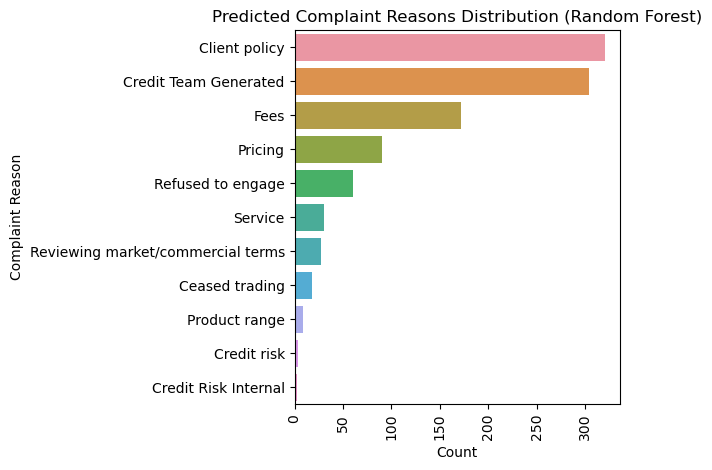

In [966]:

# Countplot for predicted complaint reasons
sns.countplot(
    y=decoded_predictions, 
    order=pd.Series(decoded_predictions).value_counts().index
)
plt.title("Predicted Complaint Reasons Distribution (Random Forest)")
plt.xlabel("Count")
plt.ylabel("Complaint Reason")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


##### Insights:
- Dominance of Client policy complaints and Credit Team Generated
- Very little importance to the complaints are categories such as: Credit Risk Internal and Credit Risk
1. Potential concern:
- The high value of "Client Policy" suggests that it is either genuinely the most frequent category in the dataset or the model has developed a bias toward predicting this category


## **Tables for Additional Insights**

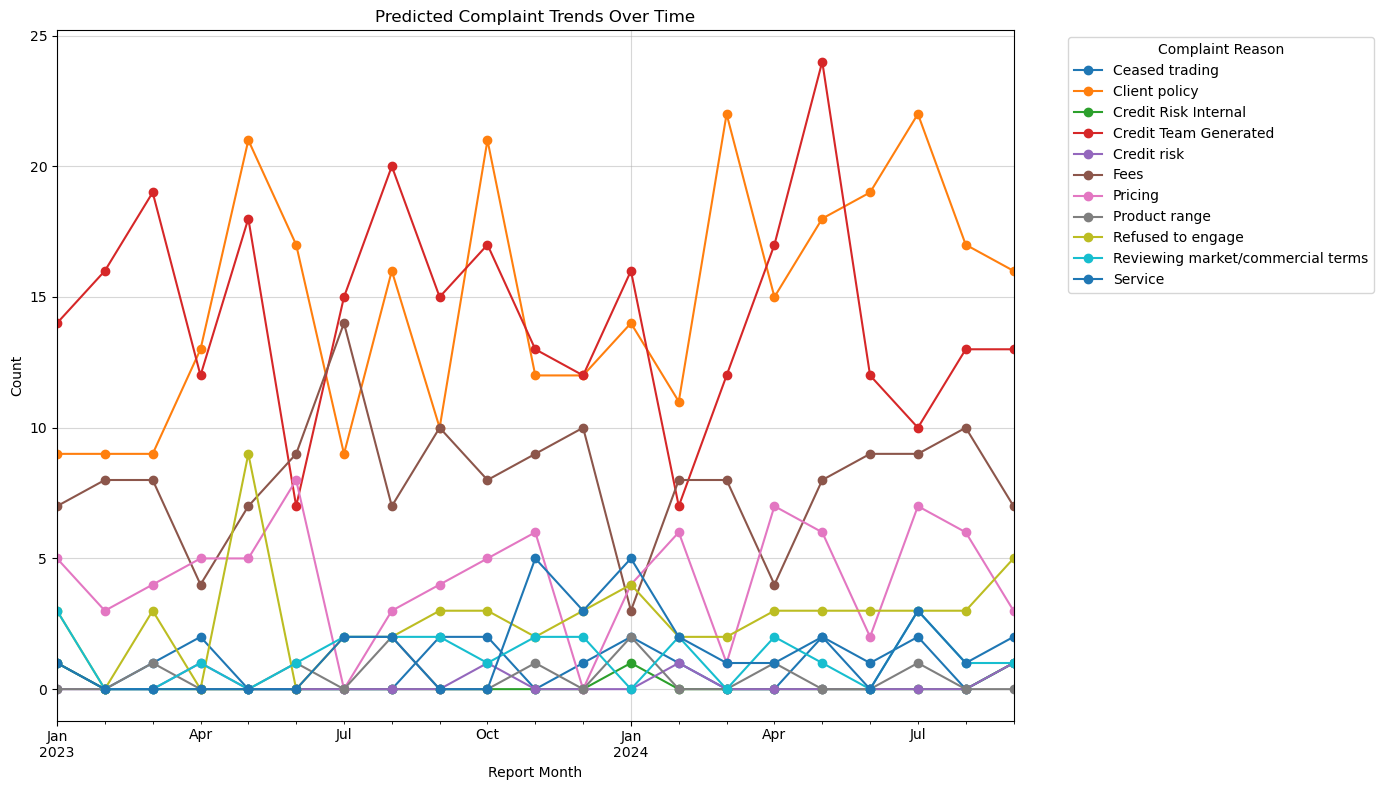

In [967]:
# Ensure monthly_reporting_df has the original indices
report_month = monthly_reporting_df['report_month']

# Reset indices for X_test to include original indices for alignment
X_test = X_test.reset_index(drop=False)

# Ensure alignment between X_test and monthly_reporting_df indices
if 'index' in X_test.columns:
    X_test['report_month'] = X_test['index'].map(report_month).values
else:
    raise ValueError("Index column not found in X_test. Check if reset_index was applied correctly.")

# Drop the extra index column if no longer needed
X_test = X_test.drop(columns=['index'])

# Decode predicted labels and true labels
decoded_predictions = [decoded_mapping[label] for label in y_pred]
decoded_true_labels = [decoded_mapping[label] for label in y_test]

# Create a DataFrame with temporal and prediction data
temporal_analysis_df = pd.DataFrame({
    'Report Month': X_test['report_month'],
    'Predicted Complaint Reason': decoded_predictions,
    'True Complaint Reason': decoded_true_labels
})

# Check for missing values in 'Report Month'
if temporal_analysis_df['Report Month'].isnull().any():
    print("Warning: Missing values found in 'Report Month'. These rows will be dropped.")
    temporal_analysis_df = temporal_analysis_df.dropna(subset=['Report Month'])

# Group by Report Month and Complaint Reasons
complaint_trends = temporal_analysis_df.groupby(['Report Month', 'Predicted Complaint Reason']).size().unstack(fill_value=0)

# Plot complaint trends over time
complaint_trends.plot(figsize=(14, 8), marker='o')
plt.title('Predicted Complaint Trends Over Time')
plt.ylabel('Count')
plt.xlabel('Report Month')
plt.grid(alpha=0.5)
plt.legend(title='Complaint Reason', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



##### Insights:
1. Trends over time:
- There are notable fluctuations for Client Policy and Credit Risk, with peaks occurring at regular intervals. This could indicate seasonality or specific events causing spikes in complaints
2. Seasonal or Cyclical Patterns:
- Certain categories, like Credit Risk and Client Policy, show peaks and troughs, suggesting that external factors or internal processes may influence complaints
3. Stability of Lower Categories
- Categories like Ceased Trading, Service, and Product Range show consistent low complaint levels over time. While these categories may not be urgent, their consistency indicates they are well-managed, or their issues are not highly impactful
4. Comparative Timing
- Synchronized spikes in categories could indicate interconnected issues


In [968]:
# Retrieve the mapping
complaint_subreason_mapping = dict(zip(le_complaint_subreason.classes_, le_complaint_subreason.transform(le_complaint_subreason.classes_)))

decoded_mapping = {v: k for k, v in complaint_subreason_mapping.items()}

# Retrieve the best Random Forest model
random_forest_clf = [
    clf for clf in clfs if clf.best_estimator_.__class__.__name__ == 'RandomForestClassifier'
][0]  # Ensure the list has at least one item

# Drop any additional columns added to X_test (e.g., report_month)
X_test_corrected = X_test.drop(columns=['report_month'], errors='ignore')

# Generate predictions for the Random Forest model
y_pred = random_forest_clf.predict(X_test_corrected)

# Decode the predictions using the complaint reason mapping
decoded_predictions = [decoded_mapping[label] for label in y_pred]

# Decode the true labels as well
decoded_true_labels = [decoded_mapping[label] for label in y_test]

# Create a DataFrame containing only Random Forest results
results_df = pd.DataFrame({
    'True Reason': decoded_true_labels,
    'Predicted Reason': decoded_predictions
})




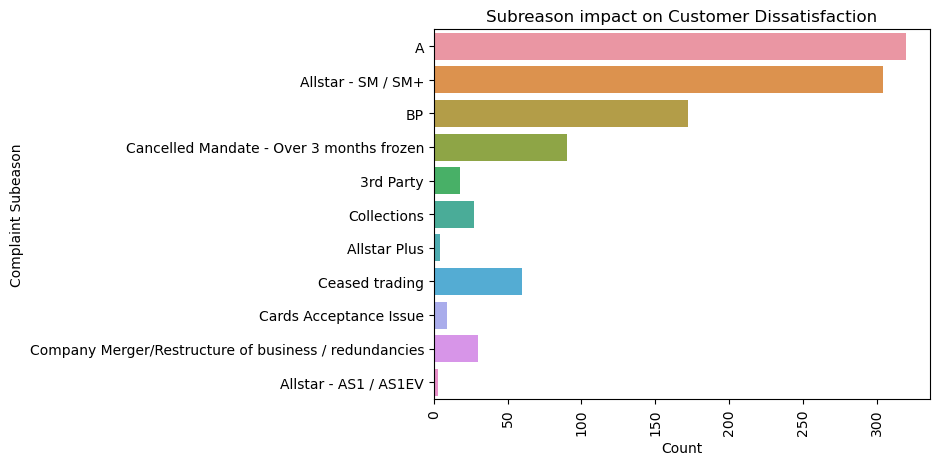

In [969]:
sns.countplot(y=decoded_predictions)
plt.title("Subreason impact on Customer Dissatisfaction")
plt.xlabel("Count")
plt.ylabel("Complaint Subeason")
plt.xticks(rotation=90)
plt.show()

##### Insights:
<br> From the table we can see that the subreasons with highest values for customer dissatisfaction are: 
<br>A
<br>Allstar - SM/SM+
<br>BP